In [2]:
from mushroom import *

C:\Users\Athena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Athena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\Athena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loading pipeline components...: 100%|██████████| 9/9 [00:14<00:00,  1.66s/it]
Pipelines loaded with `dt

In [3]:
root_folder = "mushrooms"
batch_size = 8

embeds_path = "npy_loads/embeds_all.npy"
gt_labels_path = "npy_loads/ground_truth_labels.npy"
pred_labels_path = "npy_loads/predicted_labels.npy"
species_names_path = "npy_loads/species_names.npy"
image_paths_path = "npy_loads/image_paths.npy"

if all(os.path.exists(p) for p in [embeds_path, gt_labels_path, pred_labels_path, species_names_path, image_paths_path]):
    all_embeds = np.load(embeds_path)
    ground_truth_labels = np.load(gt_labels_path)
    pred_labels = np.load(pred_labels_path)
    species_names = np.load(species_names_path, allow_pickle=True)
    image_paths = np.load(image_paths_path, allow_pickle=True)
    print("All data loaded from saved files.")
else:
    all_embeds = []
    ground_truth_labels = []
    image_paths = []

    for species in os.listdir(root_folder):
            species_folder = os.path.join(root_folder, species)
            if os.path.isdir(species_folder):
                files = sorted(f for f in os.listdir(species_folder) if f.lower().endswith(".png"))
                paths = [os.path.join(species_folder, f) for f in files]
                image_paths.extend(paths)
                ground_truth_labels.extend([species] * len(files))
                embeds = embed_whole_folder(species_folder, bs=batch_size)  # your embedding function
                all_embeds.append(embeds)

    all_embeds = np.vstack(all_embeds)
    all_embeds = normalize_embeds(all_embeds)
    ground_truth_labels = np.array(ground_truth_labels)
    species_names = list(np.unique(ground_truth_labels))
    pred_labels = classify_images(pipe, image_paths, species_names)

    np.save(embeds_path, all_embeds)
    np.save(gt_labels_path, ground_truth_labels)
    np.save(pred_labels_path, pred_labels)
    np.save(species_names_path, species_names)
    np.save(image_paths_path, image_paths)

    print("All embeddings, labels, and predictions computed and saved.")


All data loaded from saved files.


In [4]:
num_clusters = len(species_names)

kmeans_labels, kmeans_model = cluster(all_embeds, n=num_clusters)
gmm_labels, gmm_probs, gmm_model = cluster_gmm(all_embeds, k=num_clusters)
agg_labels, agg_model = cluster_agglomerative(all_embeds, k=num_clusters)
spec_labels, spec_model = cluster_spectral(all_embeds, k=num_clusters)
dbscan_labels, dbscan_model = cluster_dbscan(all_embeds, eps=0.5, min_samples=3)

C:\Users\Athena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\mixture\_gaussian_mixture.py:487: RuntimeWarning: overflow encountered in cast
  log_prob[:, k] = np.sum(np.square(y), axis=1)
C:\Users\Athena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\mixture\_gaussian_mixture.py:487: RuntimeWarning: overflow encountered in cast
  log_prob[:, k] = np.sum(np.square(y), axis=1)


In [5]:
print("KMeans silhouette score:", cluster_quality(all_embeds, kmeans_labels))
print("GMM silhouette score:", cluster_quality(all_embeds, gmm_labels))
print("Agglomerative silhouette score:", cluster_quality(all_embeds, agg_labels))
print("DBSCAN silhouette score:", cluster_quality(all_embeds, dbscan_labels))
print("Spectral silhouette score:", cluster_quality(all_embeds, spec_labels))


KMeans silhouette score: 0.08680424300224751
GMM silhouette score: 0.08680424300224751
Agglomerative silhouette score: 0.0888465861950367
DBSCAN silhouette score: 0.09936613767276346
Spectral silhouette score: 0.0949823892819439


Hmmm these scores are all very low.. Clusters are not well-separated in the embedding space. DBSCAN highest score... so desnity-based clustering better than kmeans? Kmeans and GMM identical so embeddings are all gaussian. agglomerative and spectral only slightly better. but Spectral does have the second highest so maybe there is some more organic cluster shapes eg swirls/moons. 

In [6]:
captions_path = "npy_loads/captions.npy"
cleaned_captions_path = "npy_loads/cleaned_captions.npy"
text_embeds_path = "npy_loads/text_embeds.npy"
combined_embeds_path = "npy_loads/combined_embeds.npy"

if os.path.exists(captions_path):
    captions = np.load(captions_path, allow_pickle=True)
    print("Captions loaded from file.")
else:
    captions = []
    for i in range(0, len(image_paths), batch_size):
        batch = image_paths[i:i+batch_size]
        batch_caps = caption_images(batch)
        captions.extend(batch_caps)
    np.save(captions_path, captions)
    print("Captions computed and saved.")

if os.path.exists(cleaned_captions_path):
    cleaned_captions = np.load(cleaned_captions_path, allow_pickle=True)
else:
    cleaned_captions = [clean_text_description(c) for c in captions]
    np.save(cleaned_captions_path, cleaned_captions)
    print("Cleaned captions saved.")

if os.path.exists(text_embeds_path):
    text_embeds = np.load(text_embeds_path)
else:
    text_embeds = []
    for i in range(0, len(cleaned_captions), batch_size):
        batch_texts = cleaned_captions[i:i+batch_size]
        batch_embeds = embed_texts(batch_texts).cpu().numpy()
        text_embeds.append(batch_embeds)
    text_embeds = np.vstack(text_embeds)
    text_embeds = normalize_embeds(text_embeds)
    np.save(text_embeds_path, text_embeds)
    print("Text embeddings saved.")

if os.path.exists(combined_embeds_path):
    combined_embeds = np.load(combined_embeds_path)
else:
    combined_embeds = np.concatenate([all_embeds, text_embeds], axis=1)
    np.save(combined_embeds_path, combined_embeds)
    print("Combined embeddings saved.")

k = len(species_names)
kmeans_labels2, kmeans_model2 = cluster(combined_embeds, n=k)
sil_score = cluster_quality(combined_embeds, kmeans_labels2)
print("KMeans silhouette score (with text embeddings):", sil_score)


Captions loaded from file.
KMeans silhouette score (with text embeddings): 0.15985162345597337


In [7]:
print("KMeans ARI:", adjusted_rand_score(ground_truth_labels, kmeans_labels))
print("GMM ARI:", adjusted_rand_score(ground_truth_labels, gmm_labels))
print("Agglomerative ARI:", adjusted_rand_score(ground_truth_labels, agg_labels))
print("DBSCAN ARI:", adjusted_rand_score(ground_truth_labels, dbscan_labels))
print("Spectral ARI:", adjusted_rand_score(ground_truth_labels, spec_labels))

KMeans ARI: 0.5860594736150248
GMM ARI: 0.5860594736150248
Agglomerative ARI: 0.6439957973005739
DBSCAN ARI: 0.03522403271425065
Spectral ARI: 0.6445667663285455


In [8]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(ground_truth_labels, pred_labels)
print("Zero-shot CLIP classifier accuracy:", accuracy)

Zero-shot CLIP classifier accuracy: 0.4225352112676056


With the text embeddings and a test with KMeans, the silhouette score is higher at 0.159, which is almost double what we had before. This doesn't necesarrily mean we have better clusters but it shows that our clusters are likely better separated/tighter. Spectral Labels has a higher ARI (adjusted rand index), closer to 1, ARI score, which shows that it's likely closest to the ground truth labels. 

In [9]:
k = len(species_names) 

gmm_labels_comb, gmm_probs_comb, gmm_model_comb = cluster_gmm(combined_embeds, k=k)
ari_gmm_comb = adjusted_rand_score(ground_truth_labels, gmm_labels_comb)
sil_gmm_comb = cluster_quality(combined_embeds, gmm_labels_comb)

agg_labels_comb, agg_model_comb = cluster_agglomerative(combined_embeds, k=k)
ari_agg_comb = adjusted_rand_score(ground_truth_labels, agg_labels_comb)
sil_agg_comb = cluster_quality(combined_embeds, agg_labels_comb)

spec_labels_comb, spec_model_comb = cluster_spectral(combined_embeds, k=k)
ari_spec_comb = adjusted_rand_score(ground_truth_labels, spec_labels_comb)
sil_spec_comb = cluster_quality(combined_embeds, spec_labels_comb)

dbscan_labels_comb, dbscan_model_comb = cluster_dbscan(combined_embeds, min_samples=2)
# For DBSCAN, only compute silhouette if >1 cluster
if len(np.unique(dbscan_labels_comb)) > 1:
    sil_dbscan_comb = cluster_quality(combined_embeds, dbscan_labels_comb)
else:
    sil_dbscan_comb = None
ari_dbscan_comb = adjusted_rand_score(ground_truth_labels, dbscan_labels_comb)

print("GMM ARI (combined embeds):", ari_gmm_comb, "Silhouette:", sil_gmm_comb)
print("Agglomerative ARI (combined embeds):", ari_agg_comb, "Silhouette:", sil_agg_comb)
print("Spectral ARI (combined embeds):", ari_spec_comb, "Silhouette:", sil_spec_comb)
print("DBSCAN ARI (combined embeds):", ari_dbscan_comb, "Silhouette:", sil_dbscan_comb)


C:\Users\Athena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\mixture\_gaussian_mixture.py:487: RuntimeWarning: overflow encountered in cast
  log_prob[:, k] = np.sum(np.square(y), axis=1)
C:\Users\Athena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\mixture\_gaussian_mixture.py:487: RuntimeWarning: overflow encountered in cast
  log_prob[:, k] = np.sum(np.square(y), axis=1)
C:\Users\Athena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\mixture\_gaussian_mixture.py:487: RuntimeWarning: overflow encountered in cast
  log_prob[:, k] = np.sum(np.square(y), axis=1)


GMM ARI (combined embeds): 0.15128240851458313 Silhouette: 0.15985162345597337
Agglomerative ARI (combined embeds): 0.1749732472926269 Silhouette: 0.14063479182001679
Spectral ARI (combined embeds): 0.3186290081455011 Silhouette: 0.09472470014212178
DBSCAN ARI (combined embeds): 0.04207767175135948 Silhouette: -0.003919994709663682


With the added text embeddings from BLIP, spectral clustering performed the best when the clusters were compared with the ground truth labels. However, it's still lower than the ARI when we had no text embeddings involved meaning clusters are maybe less aligned with actual species. However, with text embeddings all silhouette score increased, meaning they're all likely more visually separated and tighter. Overall, it seems spectral clustering is performing the "best" in both cases.

Basically, what we can assume from this so far:
- Text embeddings are improving local cluster separation but reducing alignment with species labels => BLIP might be adding things that are grouping images slightly differently than the actual species => NOT our goal :/ it's now possibly mixing clusters rather than actual species 
- Spectral handling mixed embeddings better  

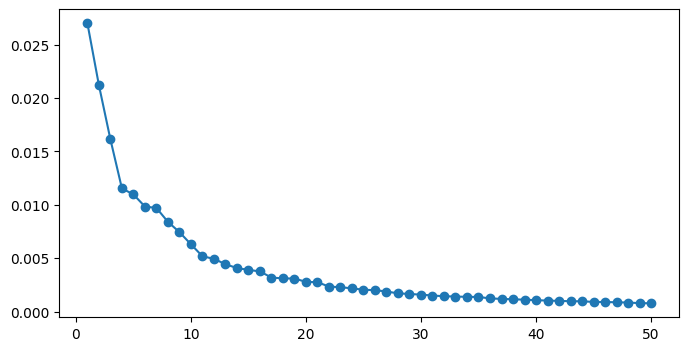

In [10]:
import seaborn as sns 
reduced_embeds, pca_model = run_pca(all_embeds, n=50)
plot_eigenvalues(pca_model)

In [11]:
pca_embeds = PCA(n_components=20).fit_transform(all_embeds)

tsne_embeds = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    init='pca'
).fit_transform(pca_embeds)

umap_embeds = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2
).fit_transform(pca_embeds)

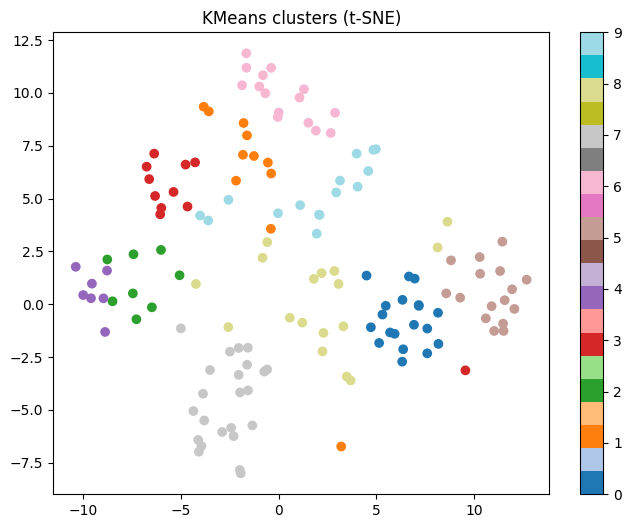

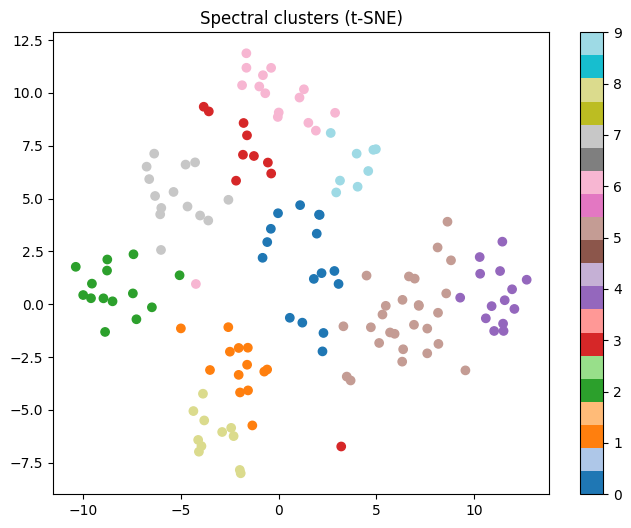

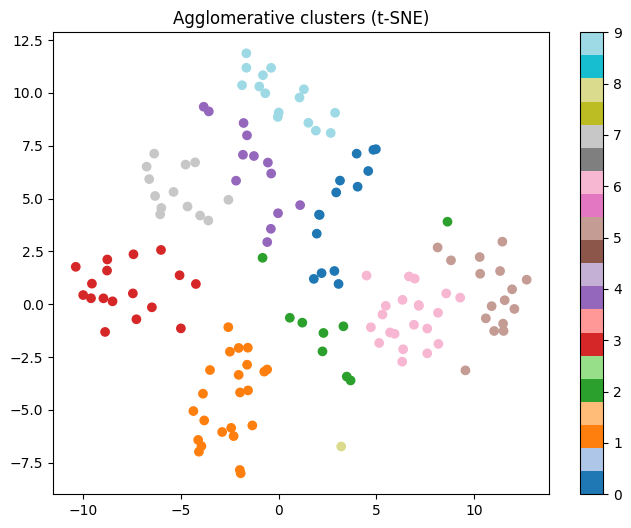

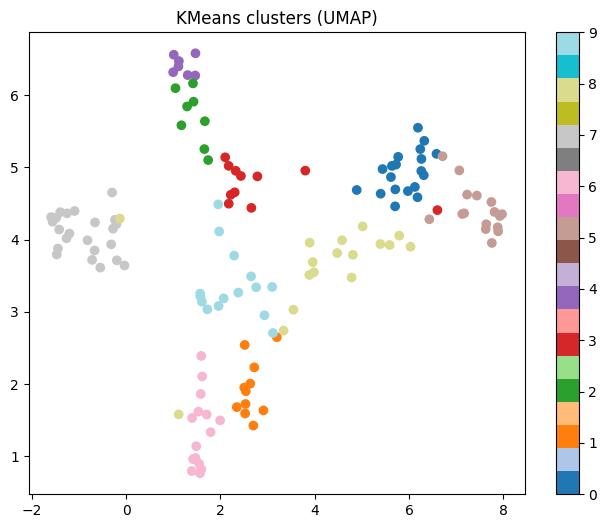

In [12]:
plot_clusters(tsne_embeds, kmeans_labels, title="KMeans clusters (t-SNE)")
plot_clusters(tsne_embeds, spec_labels, title="Spectral clusters (t-SNE)")
plot_clusters(tsne_embeds, agg_labels, title="Agglomerative clusters (t-SNE)")

plot_clusters(umap_embeds, kmeans_labels, title="KMeans clusters (UMAP)")


Hmm. We can see that some of the clusters are not spherical and perfectly evenly sized. Spectral seems to be doing better visually too. 

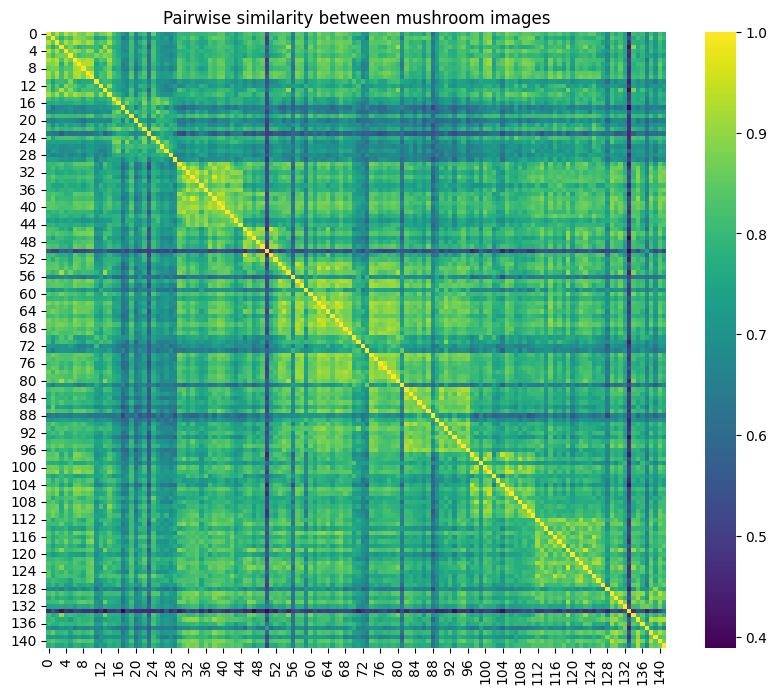

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

sim_matrix = cosine_similarity(all_embeds)

plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix, cmap="viridis")
plt.title("Pairwise similarity between mushroom images")
plt.show()

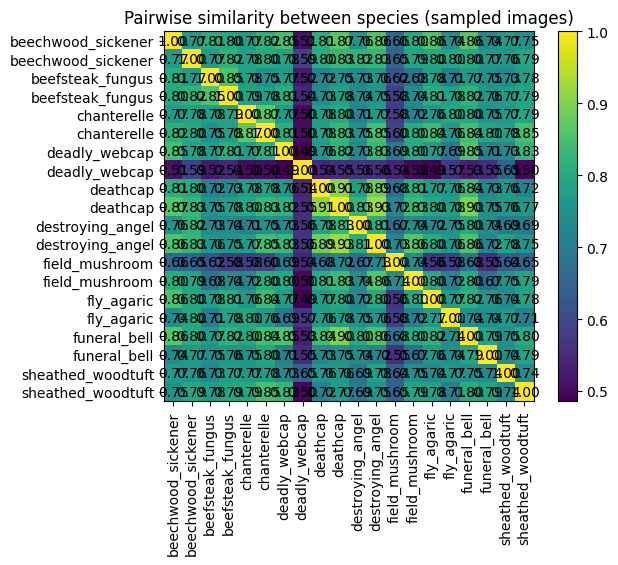

In [14]:
import random

subset_idx = []
images_per_species = 2

for species in species_names:
    idxs = [i for i, label in enumerate(ground_truth_labels) if label == species]
    subset_idx.extend(random.sample(idxs, min(len(idxs), images_per_species)))

subset_embeds = all_embeds[subset_idx]
subset_sims = cosine_similarity(subset_embeds)

fig, ax = plt.subplots()
im = ax.imshow(subset_sims, cmap='viridis')

for i in range(subset_sims.shape[0]):
    for j in range(subset_sims.shape[1]):
        ax.text(j, i, f"{subset_sims[i, j]:.2f}", ha='center', va='center', color='black')

plt.colorbar(im)
ax.set_xticks(range(len(subset_idx)))
ax.set_yticks(range(len(subset_idx)))
ax.set_xticklabels([ground_truth_labels[i] for i in subset_idx], rotation=90)
ax.set_yticklabels([ground_truth_labels[i] for i in subset_idx])
ax.set_title("Pairwise similarity between species (sampled images)")
plt.show()

^This tells us that there's moderately high similarity between different species, they're all around 0.7~0.8. This is probably why embeddings may be having trouble separating species and clusters (not tight/ low silhouette score)

The most distinct species we see is destroying angel compared to either deadly webcap or sheathed woodtuft. 

Overall, this entire notebook tells us that the clusters are not weell separated. Spectral clustering does well both visually, in terms of silhouette score and ARI. From here on out, spectral clustering is probably best for next experiments. 

The species are all similar, we're capturing some similarity but not enough because they probably share too many similarities. 

While BLIP increased clustering tightness, it may have introduced noise and clustering based on surface-differences like "brown mushrooms".

If we continue with text embeddings, we may need to weigh them less.Or we may need to use better details like gills, cap edges, texture, rather than simple captions generrated like "brown".   

# Experiment with Weighted combined embeddings 
testing various weights for image vs. text embeddings. so we are ranging from either 100% image to 100% text. Then we use spectral clustering on each weighted combination and evaluate with ARI and silhouette scores. 

In [ ]:
# Experiment with weighted combined embeddings
# Weigh image embeddings more heavily since text embeddings misalign with species labels

# Define weights for image embeddings (text weight = 1 - image_weight)
image_weights = [1.0, 0.9, 0.8, 0.7, 0.5, 0.0]  # 1.0 = only image, 0.0 = only text

results = []
best_labels = None
best_weighted_embeds = None

for img_w in image_weights:
    txt_w = 1.0 - img_w
    
    # Create weighted combination
    weighted_embeds = img_w * all_embeds + txt_w * text_embeds
    
    # Normalize the weighted embeddings
    weighted_embeds = normalize_embeds(weighted_embeds)
    
    # Cluster using spectral clustering
    spec_labels_w, spec_model_w = cluster_spectral(weighted_embeds, k=len(species_names))
    
    # Evaluate
    ari = adjusted_rand_score(ground_truth_labels, spec_labels_w)
    sil = cluster_quality(weighted_embeds, spec_labels_w)
    
    results.append({
        'image_weight': img_w,
        'text_weight': txt_w,
        'ARI': ari,
        'Silhouette': sil
    })
    
    print(f"Image weight {img_w:.1f}, Text weight {txt_w:.1f}: ARI={ari:.4f}, Silhouette={sil:.4f}")
    
    # Track best
    if best_labels is None or ari > max(r['ARI'] for r in results[:-1]):
        best_labels = spec_labels_w
        best_weighted_embeds = weighted_embeds

# Find best weight
best_result = max(results, key=lambda x: x['ARI'])
print(f"\nBest ARI: {best_result['ARI']:.4f} with image_weight={best_result['image_weight']:.1f}")

# Visualize the best weighted embeddings
if best_result['image_weight'] != 1.0:
    # Reduce to 2D with UMAP for visualization
    pca_temp = PCA(n_components=20).fit_transform(best_weighted_embeds)
    umap_best = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2).fit_transform(pca_temp)
    
    plot_clusters(umap_best, best_labels, 
                  title=f"Best weighted clusters (img_w={best_result['image_weight']:.1f}, ARI={best_result['ARI']:.4f})")

Image weight 1.0, Text weight 0.0: ARI=0.6446, Silhouette=0.0950
Image weight 0.9, Text weight 0.1: ARI=0.5977, Silhouette=0.0989
Image weight 0.8, Text weight 0.2: ARI=0.4988, Silhouette=0.0867
Image weight 0.7, Text weight 0.3: ARI=0.3704, Silhouette=0.0986
Image weight 0.5, Text weight 0.5: ARI=0.3115, Silhouette=0.1161
Image weight 0.0, Text weight 1.0: ARI=0.2047, Silhouette=0.0489

Best ARI: 0.6446 with image_weight=1.0
Image weight 0.7, Text weight 0.3: ARI=0.3704, Silhouette=0.0986
Image weight 0.5, Text weight 0.5: ARI=0.3115, Silhouette=0.1161
Image weight 0.0, Text weight 1.0: ARI=0.2047, Silhouette=0.0489

Best ARI: 0.6446 with image_weight=1.0


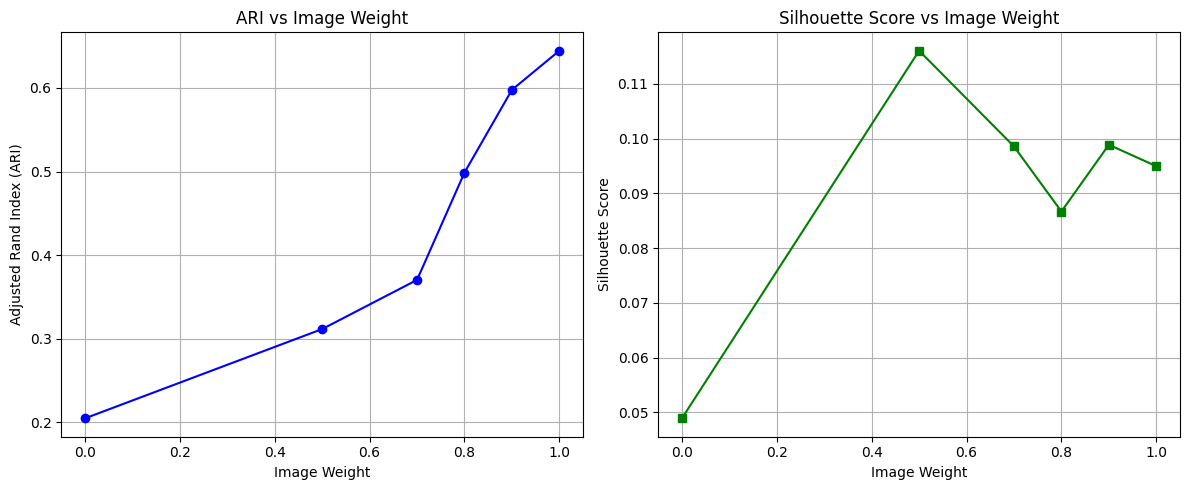

In [20]:
# Visualize the results: ARI and Silhouette vs Image Weight
image_weights_plot = [r['image_weight'] for r in results]
ari_scores = [r['ARI'] for r in results]
sil_scores = [r['Silhouette'] for r in results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ARI plot
ax1.plot(image_weights_plot, ari_scores, marker='o', linestyle='-', color='blue')
ax1.set_xlabel('Image Weight')
ax1.set_ylabel('Adjusted Rand Index (ARI)')
ax1.set_title('ARI vs Image Weight')
ax1.grid(True)

# Silhouette plot
ax2.plot(image_weights_plot, sil_scores, marker='s', linestyle='-', color='green')
ax2.set_xlabel('Image Weight')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Image Weight')
ax2.grid(True)

plt.tight_layout()
plt.show()

From the ARI and silhouette scores, we see that the text embeddings are introducing noise that reduces alignment with species labels. The ARI is highest when using only image embeddings (weight 1.0) and decreases as text weight increases, confirming that the BLIP captions are grouping images by superficial and un-identifying features rather than species-specific traits.

However, the silhouette score (which measures cluster tightness) improves slightly with some text weight. This  indicats that text embeddings do help somewhat separate clusters, but at the cost of accuracy. While text provides some complementary information, it is not reliable

If we do choose to incorporate text embeddings from BLIP, the best balance would be a high image weight and we would prioritize visual features for species identification.